In [307]:
%reload_ext autoreload
%autoreload 2

import gc
import logging
from functools import partial
import random

# numpy et pandas pour la manipulation du data
import numpy as np
import pandas as pd

import plotly.express as px

from lightgbm import LGBMClassifier

from lime.lime_tabular import LimeTabularExplainer
import shap
shap.initjs()

# sklearn preprocessing pour traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.base import ClassifierMixin, is_classifier
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing, model_selection, linear_model, neighbors, metrics, datasets, impute, ensemble
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score, mean_squared_error, r2_score, roc_auc_score, average_precision_score
from sklearn.linear_model import RidgeClassifier
from lightgbm.sklearn import LGBMRegressor
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE

from hyperopt import fmin, tpe, hp, anneal, Trials, space_eval

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour tracer les graphes
import matplotlib.pyplot as plt
import seaborn as sns

#autres librairies
import missingno as msno

# Import des modules contenant les fonctions utilitaires
import src.my_module.data_helpers as dth

In [520]:
# Réglage des graphiques
plt.style.use('seaborn-whitegrid')

plt.rc('font', size=12)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

dims_fig = (25,35)

In [146]:
data = pd.read_csv('merge2.csv')
dth.displayDataShape("Le jeu de données contient", data)

Le jeu de données contient : 356251 lignes et 798 colonnes



In [147]:
train_data = data[data['TARGET'].notnull()]
test_data = data[data['TARGET'].isnull()]

In [148]:
dth.displayDataShape("Le jeu d'entraînement contient", train_data)

Le jeu d'entraînement contient : 307507 lignes et 798 colonnes



In [149]:
dth.displayDataShape("Le jeu de test contient", test_data)

Le jeu de test contient : 48744 lignes et 798 colonnes



In [150]:
del data
gc.collect()

21625

In [151]:
train_data.head()

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      0      100002     1.0            0             0                0   
1      1      100003     0.0            1             0                1   
2      2      100004     0.0            0             1                0   
3      3      100006     0.0            1             0                0   
4      4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0             0          202500.0    406597.5      24700.5  ...   
1             0          270000.0   1293502.5      35698.5  ...   
2             0           67500.0    135000.0       6750.0  ...   
3             0          135000.0    312682.5      29686.5  ...   
4             0          121500.0    513000.0      21865.5  ...   

   CC_NAME_CONTRACT_STATUS_Signed_MAX  CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 0.0                                  0.0   
4                                 NaN                                  NaN   

   CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 0.0                                 0.0   
4                                 NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              0.0                              0.0   
4                              NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               0.0                              0.0   
4                               NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN       NaN  
1                              NaN       NaN  
2                              NaN       NaN  
3                              0.0       6.0  
4                              NaN       NaN  

[5 rows x 798 columns]

In [152]:
feature_importance = pd.read_csv('feature_importance.csv').sort_values("importance", ascending=False)
feature_importance.head()

feature  importance  fold
3424  PAYMENT_RATE        3955     5
5014  PAYMENT_RATE        3872     7
32    EXT_SOURCE_3        3868     1
6604  PAYMENT_RATE        3764     9
7187  EXT_SOURCE_3        3753    10

In [153]:
test = feature_importance.groupby('feature').mean().sort_values("importance", ascending=False)
test.describe()

importance   fold
count   795.00000  795.0
mean    371.15673    5.5
std     549.11526    0.0
min       0.00000    5.5
25%      16.60000    5.5
50%     133.70000    5.5
75%     491.25000    5.5
max    3683.40000    5.5

In [154]:
list_features = test[:100].index
new_train_data = train_data[list_features.insert(0, 'TARGET')]
new_test_data = test_data[list_features]

### Préparation des données

In [155]:
X = new_train_data.drop(['TARGET'], axis=1)
y = new_train_data['TARGET']

In [156]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

### Normalisation des données

In [157]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = pd.DataFrame(
    std_scale.transform(X_train),
    columns=X_train.columns
)
X_test_std = pd.DataFrame(
    std_scale.transform(X_test),
    columns=X_test.columns
)

In [158]:
X_train_std.describe()

PAYMENT_RATE  EXT_SOURCE_3  EXT_SOURCE_2    DAYS_BIRTH  EXT_SOURCE_1  \
count  2.459970e+05  1.973450e+05  2.454860e+05  2.460050e+05  1.074680e+05   
mean   3.565394e-18 -8.008998e-17  2.794132e-16 -1.547583e-16  6.282255e-16   
std    1.000002e+00  1.000003e+00  1.000002e+00  1.000002e+00  1.000005e+00   
min   -1.407666e+00 -2.620843e+00 -2.690063e+00 -2.106760e+00 -2.308901e+00   
25%   -7.470873e-01 -7.204561e-01 -6.398183e-01 -8.350448e-01 -7.960376e-01   
50%   -1.645881e-01  1.248164e-01  2.705507e-01  6.730014e-02  1.792930e-02   
75%    4.610144e-01  8.117098e-01  7.809975e-01  8.305584e-01  8.202071e-01   
max    3.148304e+00  1.976995e+00  1.782291e+00  1.958146e+00  2.114070e+00   

       DAYS_EMPLOYED  DAYS_EMPLOYED_PERC  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count   2.017020e+05        2.017020e+05       2.460050e+05     2.460050e+05   
mean    4.465837e-17       -3.841025e-16      -8.726695e-17    -2.043040e-17   
std     1.000002e+00        1.000002e+00       1.000002e+00     1.000002e+00   
min    -6.503323e+00       -1.173616e+00      -5.587373e+00    -2.785596e+00   
25%    -3.396057e-01       -7.554626e-01      -7.071798e-01    -8.637800e-01   
50%     3.153989e-01       -2.858676e-01       1.362683e-01    -1.723503e-01   
75%     6.923153e-01        4.666567e-01       8.454799e-01     8.439121e-01   
max     1.019176e+00        4.237433e+00       1.414495e+00     1.985467e+00   

       INSTAL_DBD_MEAN  ...  PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN  \
count     2.332920e+05  ...                             2.328100e+05   
mean      1.141013e-16  ...                            -1.309357e-15   
std       1.000002e+00  ...                             1.000002e+00   
min      -1.345134e+00  ...                            -9.585389e-01   
25%      -6.129139e-01  ...                            -9.585389e-01   
50%      -2.350082e-01  ...                            -1.156064e-01   
75%       3.156088e-01  ...                             7.273261e-01   
max       3.100801e+01  ...                             2.413191e+00   

       CLOSED_DAYS_CREDIT_MIN  CLOSED_DAYS_CREDIT_ENDDATE_MIN  \
count            1.842750e+05                    1.830560e+05   
mean            -3.187670e-17                    1.846591e-17   
std              1.000003e+00                    1.000003e+00   
min             -1.315863e+00                   -2.569912e+01   
25%             -9.229436e-01                   -5.268217e-01   
50%             -1.571909e-01                   -5.146777e-02   
75%              8.382877e-01                    4.030539e-01   
max              2.339665e+00                    2.054531e+01   

       PREV_AMT_CREDIT_MEAN  PREV_RATE_DOWN_PAYMENT_MEAN  \
count          2.328100e+05                 2.187920e+05   
mean           1.552739e-16                -9.681133e-16   
std            1.000002e+00                 1.000002e+00   
min           -1.029380e+00                -9.147839e-01   
25%           -6.238938e-01                -9.147003e-01   
50%           -3.172162e-01                -1.744466e-01   
75%            2.796550e-01                 3.015495e-01   
max            2.032639e+01                 1.013774e+01   

       APPROVED_APP_CREDIT_PERC_MIN  TOTALAREA_MODE  INSTAL_PAYMENT_PERC_VAR  \
count                  2.320270e+05    1.274090e+05             2.327310e+05   
mean                   3.298770e-15    1.526946e-16            -1.806662e-15   
std                    1.000002e+00    1.000004e+00             1.000002e+00   
min                   -2.382498e+00   -9.560956e-01            -5.714813e-03   
25%                    2.504881e-02   -5.714793e-01            -5.714813e-03   
50%                    2.550166e-01   -3.147572e-01            -5.714813e-03   
75%                    5.334912e-01    2.341613e-01            -5.714789e-03   
max                    1.219745e+01    8.379253e+00             2.761657e+02   

       INSTAL_AMT_PAYMENT_MAX  PREV_AMT_APPLICATION_MEAN  
count            2

In [159]:
#msno.bar(X_train_std)

### Imputation des valeurs manquantes

In [160]:
imputer = impute.IterativeImputer(n_nearest_features=min(5, int(len(X_train_std.columns) / 10))).fit(X_train_std)

X_train_std = pd.DataFrame(
    imputer.transform(X_train_std),
    columns=X_train_std.columns
)

X_test_std = pd.DataFrame(
    imputer.transform(X_test_std),
    columns=X_test_std.columns
)

### Analyse en composantes principales (ACP)

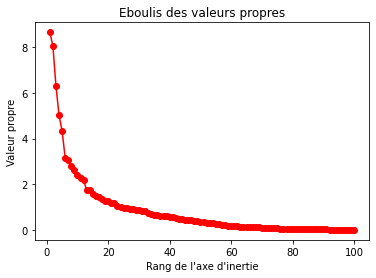

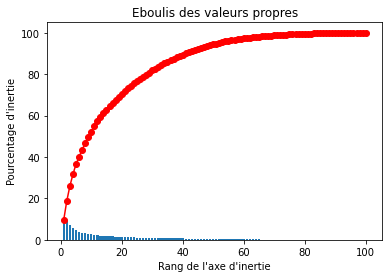

Le nombre de composantes à analyser est de 28


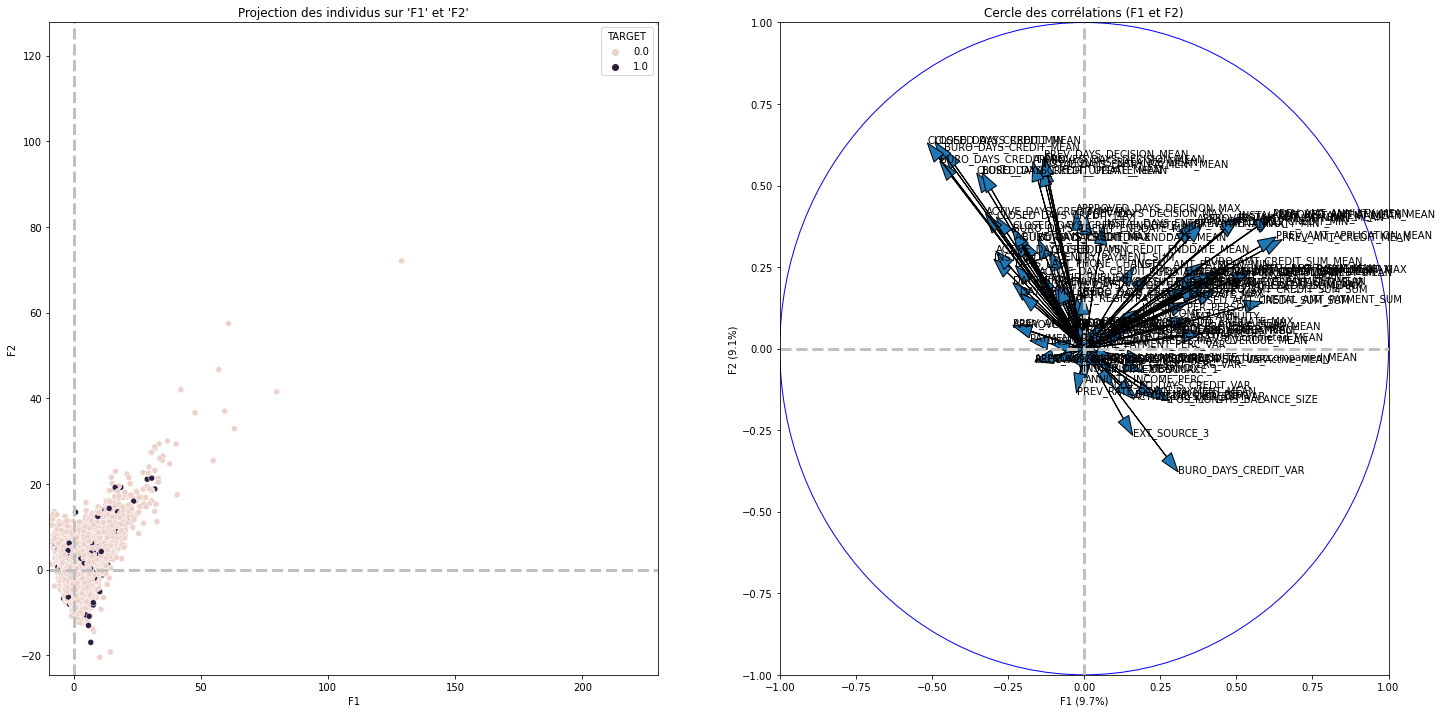

In [501]:
dth.acpAnalysis(X_train_std, y_train)

### Modélisation et évaluation des modèles

In [162]:
results = {}

#### Modèle de référence

100%|██████████| 10/10 [00:06<00:00,  1.49trial/s, best loss: 0.014489705493790778]
Meilleurs paramètres : {'strategy': 'most_frequent'}


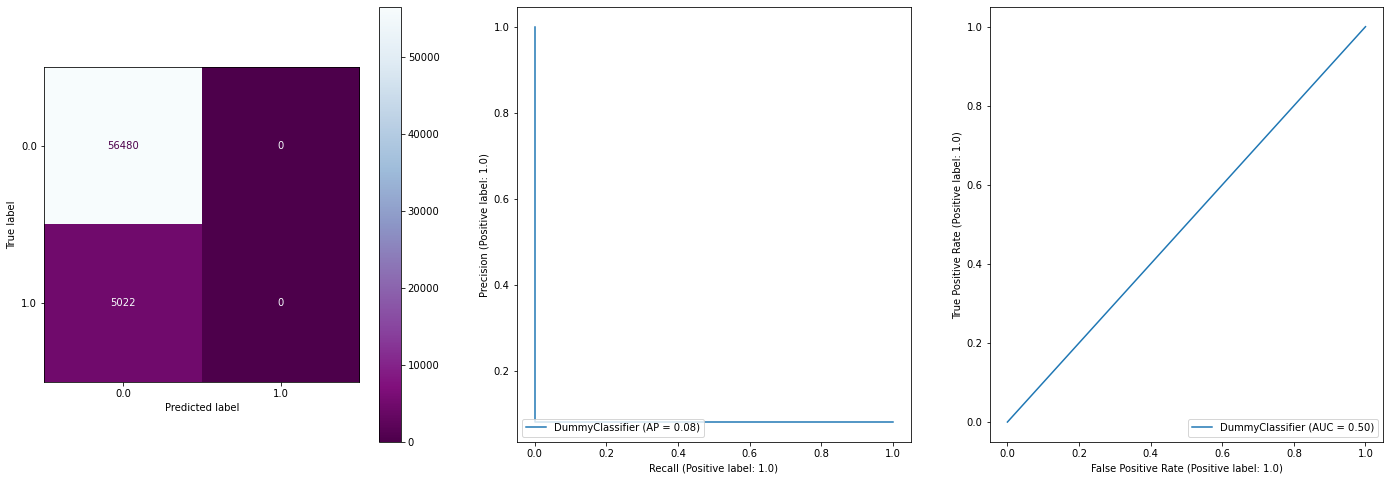

In [163]:
dummy_classifier = DummyClassifier(random_state=42)

space = {
        'strategy': hp.choice('strategy', ['stratified', 'most_frequent', 'prior', 'uniform'])
    }

dummyClassifier_results = dth.find_best_parameters(dummy_classifier, space, X_train_std, y_train, X_test_std, y_test, smote=False)

results['dummyClassifier'] = dummyClassifier_results

print(f"Meilleurs paramètres : {dummyClassifier_results['Best params']}")

dth.plot_classifier_results(dummyClassifier_results['Classifier'], X_test_std, y_test)

100%|██████████| 10/10 [07:51<00:00, 47.14s/trial, best loss: 0.013962480437389485]
Meilleurs paramètres : {'alpha': 18370.500757440783, 'fit_intercept': False, 'normalize': False, 'solver': 'sag'}


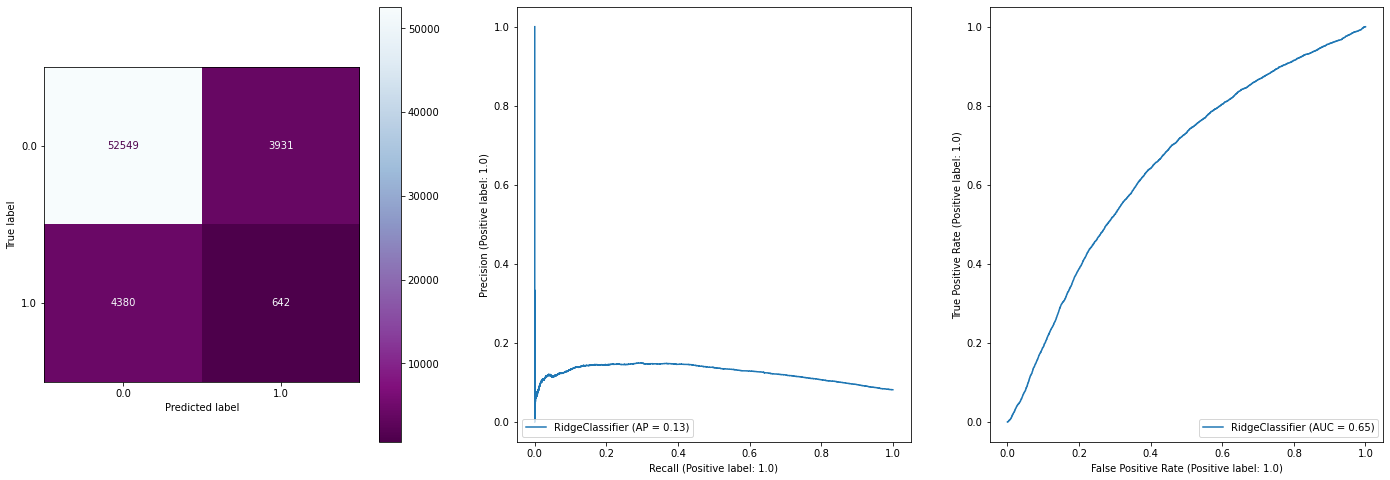

In [164]:
#SANS LE SMOTE

ridgeClassifierModel_noSmote = linear_model.RidgeClassifier(random_state=42)

space = {
        'alpha': hp.loguniform('alpha', -10, 10),
        'fit_intercept': hp.choice('fit_intercept', [True, False]),
        'normalize': hp.choice('normalize', [True, False]),
        'solver': hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    }

ridgeClassifier_noSmote_results = dth.find_best_parameters(ridgeClassifierModel_noSmote, space, X_train_std, y_train, X_test_std, y_test, smote=False)

results['ridgeClassifier_noSmote'] = ridgeClassifier_noSmote_results

print(f"Meilleurs paramètres : {ridgeClassifier_noSmote_results['Best params']}")

dth.plot_classifier_results(ridgeClassifier_noSmote_results['Classifier'], X_test_std, y_test)

100%|██████████| 10/10 [32:37<00:00, 195.76s/trial, best loss: 0.010367594154590355]
Meilleurs paramètres : {'alpha': 0.7505689576188825, 'fit_intercept': True, 'normalize': False, 'solver': 'sag'}


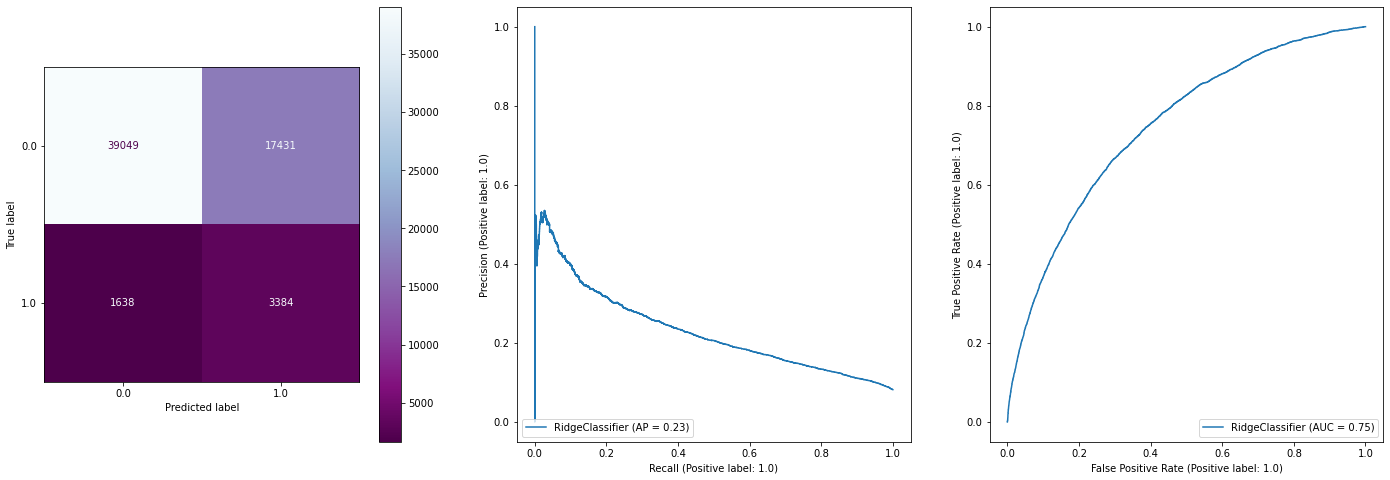

In [165]:
#AVEC LE SMOTE

ridgeClassifierModel = linear_model.RidgeClassifier(random_state=42)

space = {
        'alpha': hp.loguniform('alpha', -10, 10),
        'fit_intercept': hp.choice('fit_intercept', [True, False]),
        'normalize': hp.choice('normalize', [True, False]),
        'solver': hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    }

ridgeClassifier_results = dth.find_best_parameters(ridgeClassifierModel, space, X_train_std, y_train, X_test_std, y_test, smote=True)

results['ridgeClassifier'] = ridgeClassifier_results

print(f"Meilleurs paramètres : {ridgeClassifier_results['Best params']}")

dth.plot_classifier_results(ridgeClassifier_results['Classifier'], X_test_std, y_test)

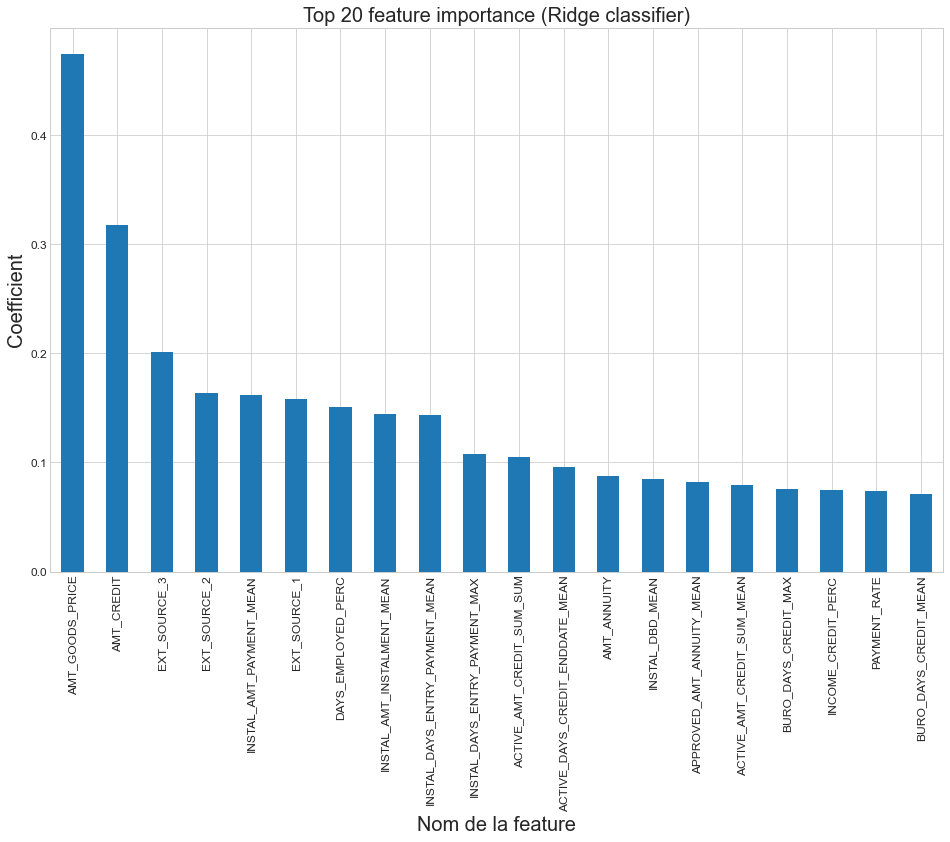

In [524]:
top_coefficients = pd.Series(
            ridgeClassifier_results['Classifier'].coef_[0],
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)
        
plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (Ridge classifier)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

100%|██████████| 10/10 [1:21:37<00:00, 489.72s/trial, best loss: 0.011396435031808299]
Meilleurs paramètres : {'max_depth': 11, 'max_features': 'sqrt'}


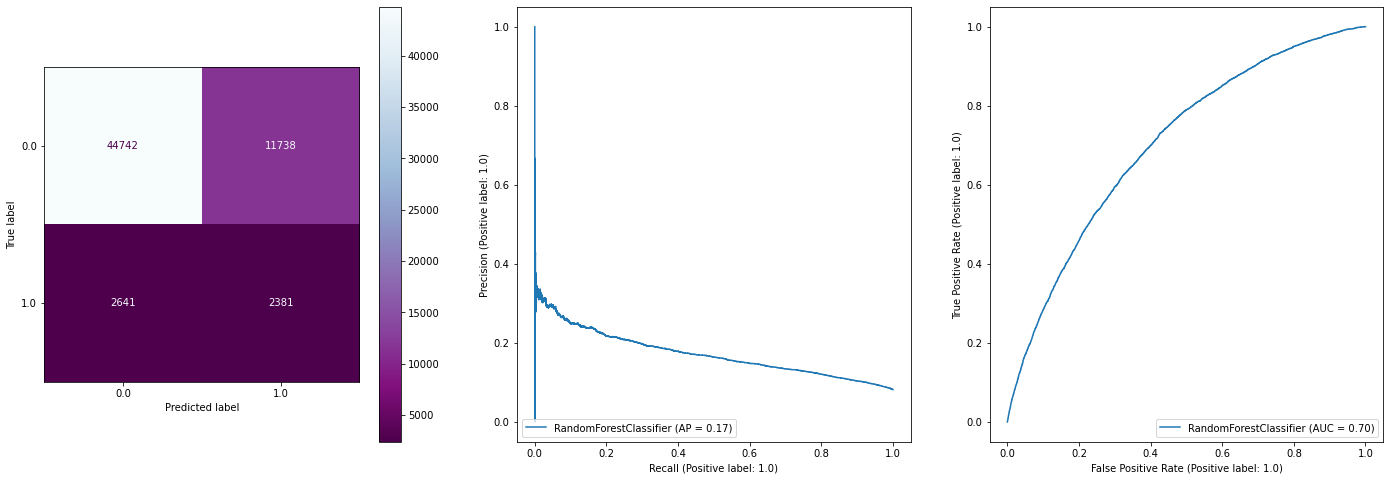

In [167]:
randomForestModel = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

space = {
        'max_depth': hp.choice('max_depth', [None] + list(range(2, 20, 3))),
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2'])
        }

randomForest_results = dth.find_best_parameters(randomForestModel, space, X_train_std, y_train, X_test_std, y_test, smote=True)

results['randomForestClassifier'] = randomForest_results

print(f"Meilleurs paramètres : {randomForest_results['Best params']}")

dth.plot_classifier_results(randomForest_results['Classifier'], X_test_std, y_test)

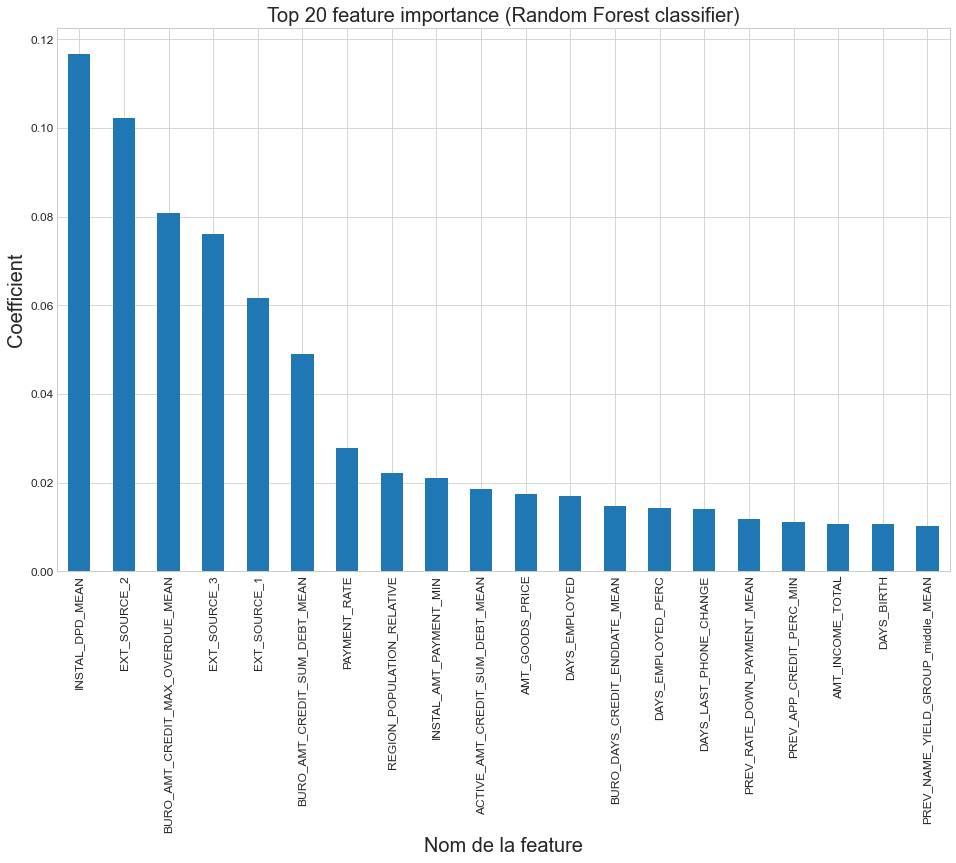

In [525]:
top_coefficients = pd.Series(
            randomForest_results['Classifier'].feature_importances_,
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (Random Forest classifier)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

100%|██████████| 10/10 [44:02<00:00, 264.25s/trial, best loss: 0.010393853783459688]
Meilleurs paramètres : {'max_depth': 8, 'max_features': 'auto'}


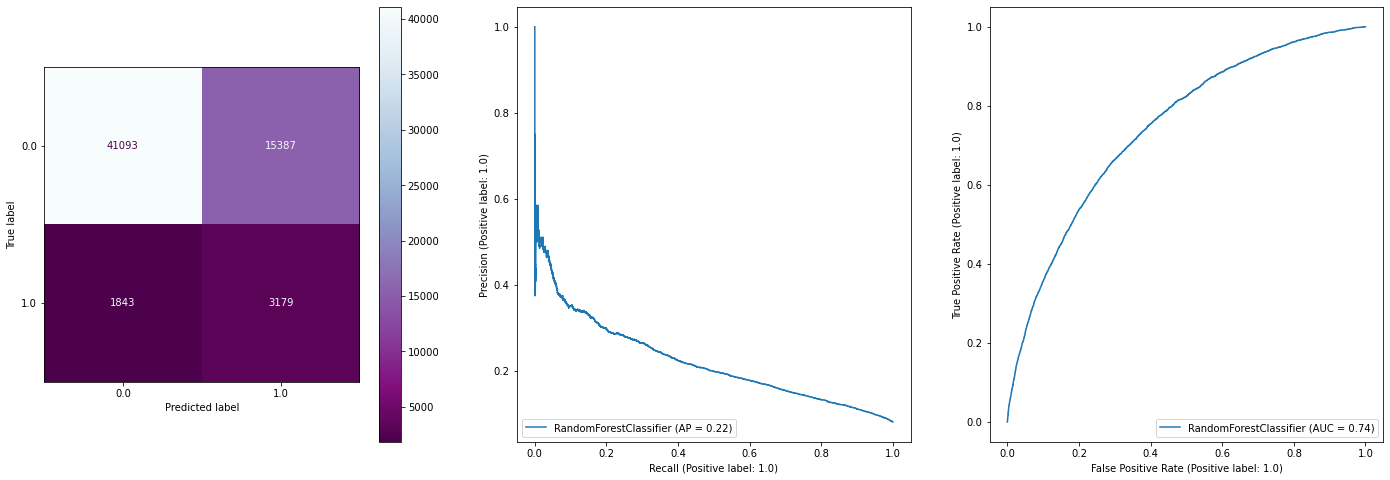

In [357]:
randomForestModel_classWeight = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')

space = {
        'max_depth': hp.choice('max_depth', [None] + list(range(2, 20, 3))),
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2'])
        }

randomForest_classWeight_results = dth.find_best_parameters(randomForestModel_classWeight, space, X_train_std, y_train, X_test_std, y_test, smote=False)

results['randomForestClassifier_classWeight'] = randomForest_classWeight_results

print(f"Meilleurs paramètres : {randomForest_classWeight_results['Best params']}")

dth.plot_classifier_results(randomForest_classWeight_results['Classifier'], X_test_std, y_test)

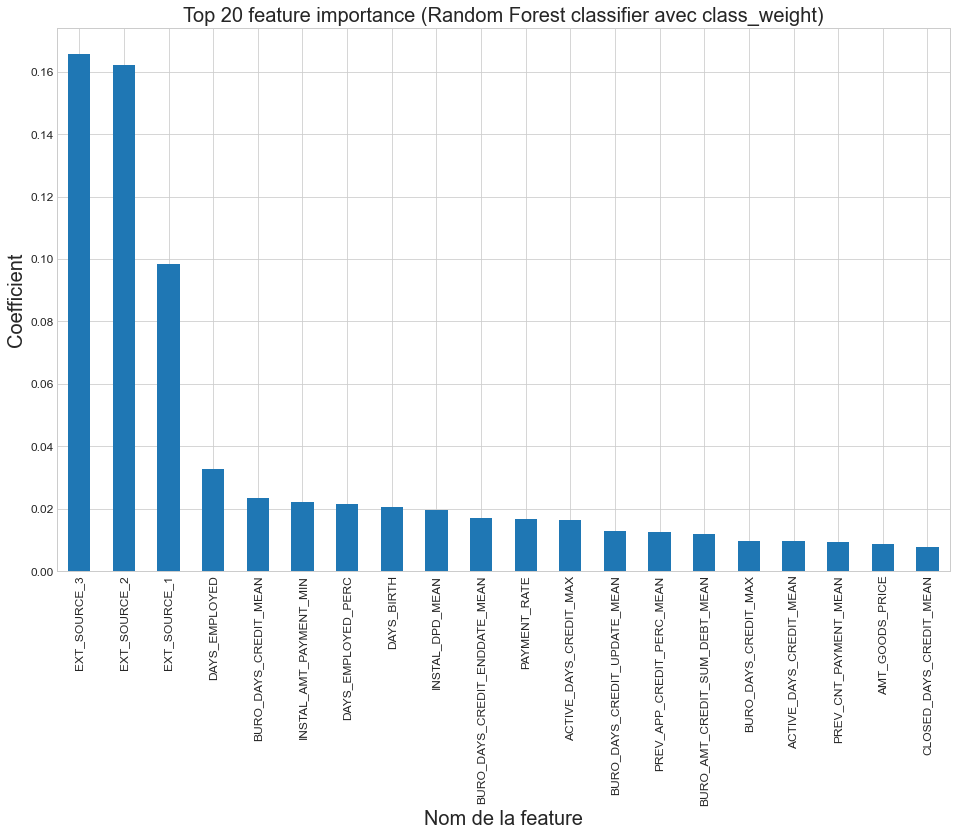

In [526]:
top_coefficients = pd.Series(
            randomForest_classWeight_results['Classifier'].feature_importances_,
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (Random Forest classifier avec class_weight)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

100%|██████████| 10/10 [11:25<00:00, 68.52s/trial, best loss: 0.012340968679498384]
Best parameters : {'max_depth': 3}


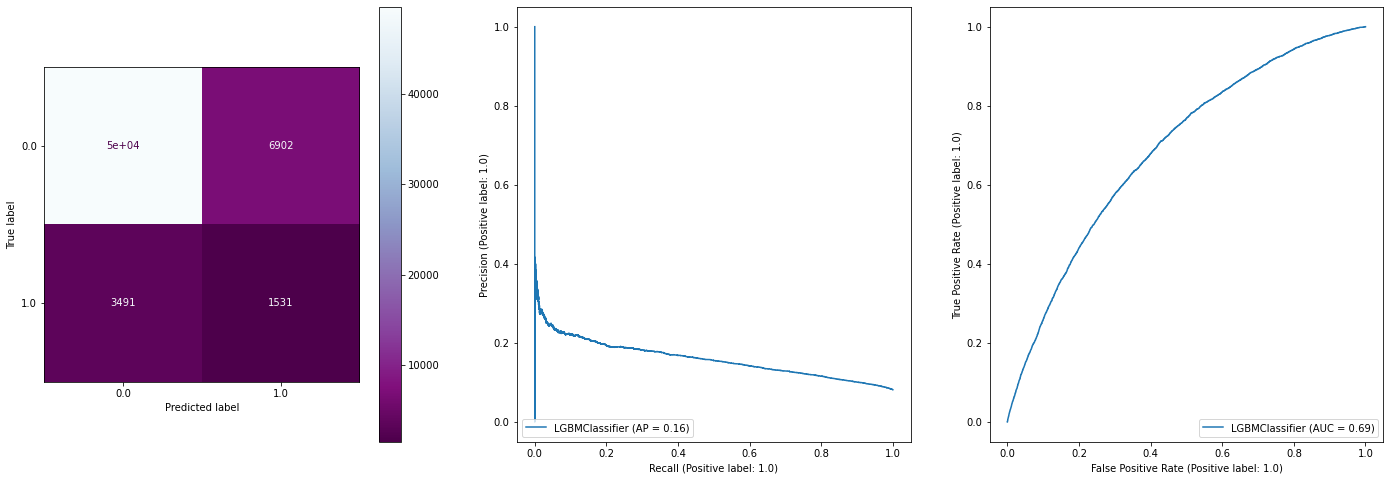

In [346]:
lgbmModel = LGBMClassifier(n_jobs=-1, random_state=42, objective='binary')

space = {
        'max_depth': hp.choice('max_depth', [None] + list(range(0, 22, 3)))
        }

lgbmClassifier_results = dth.find_best_parameters(lgbmModel, space, X_train_std, y_train, X_test_std, y_test, smote=True)

results['lgbmClassifier'] = lgbmClassifier_results

print(f"Best parameters : {lgbmClassifier_results['Best params']}")

dth.plot_classifier_results(lgbmClassifier_results['Classifier'], X_test_std, y_test)

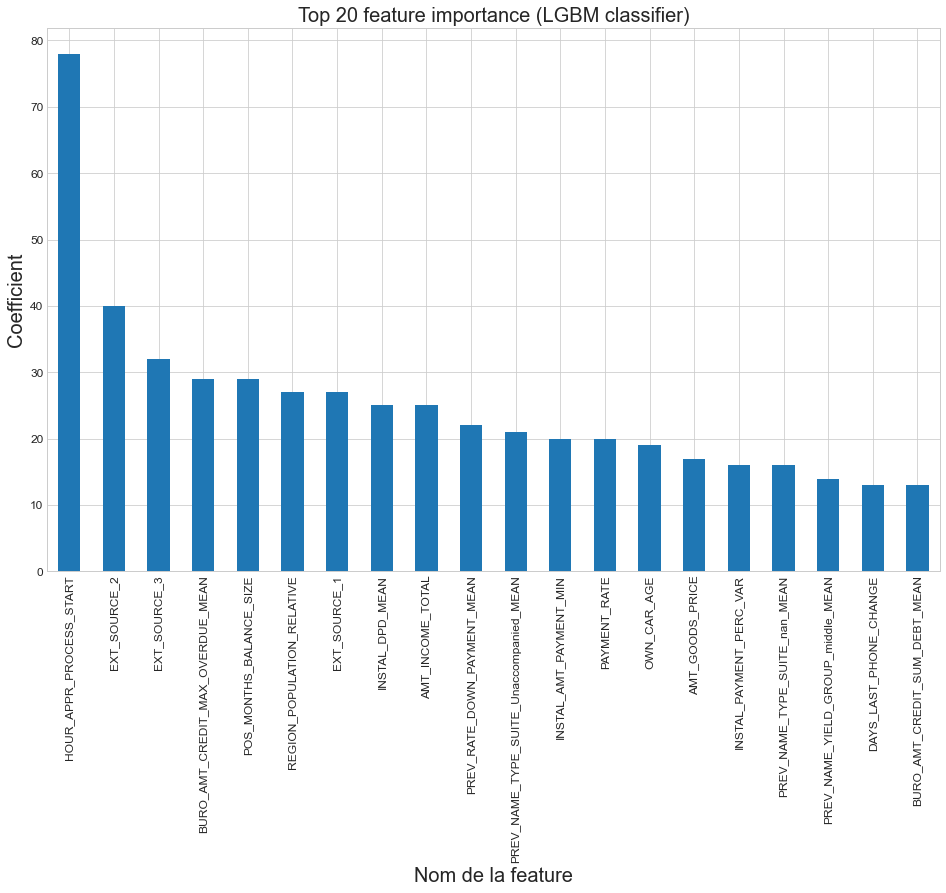

In [527]:
top_coefficients = pd.Series(
            lgbmClassifier_results['Classifier'].feature_importances_,
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (LGBM classifier)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

100%|██████████| 10/10 [05:31<00:00, 33.12s/trial, best loss: 0.00968451860734538]
Best parameters : {'max_depth': None}


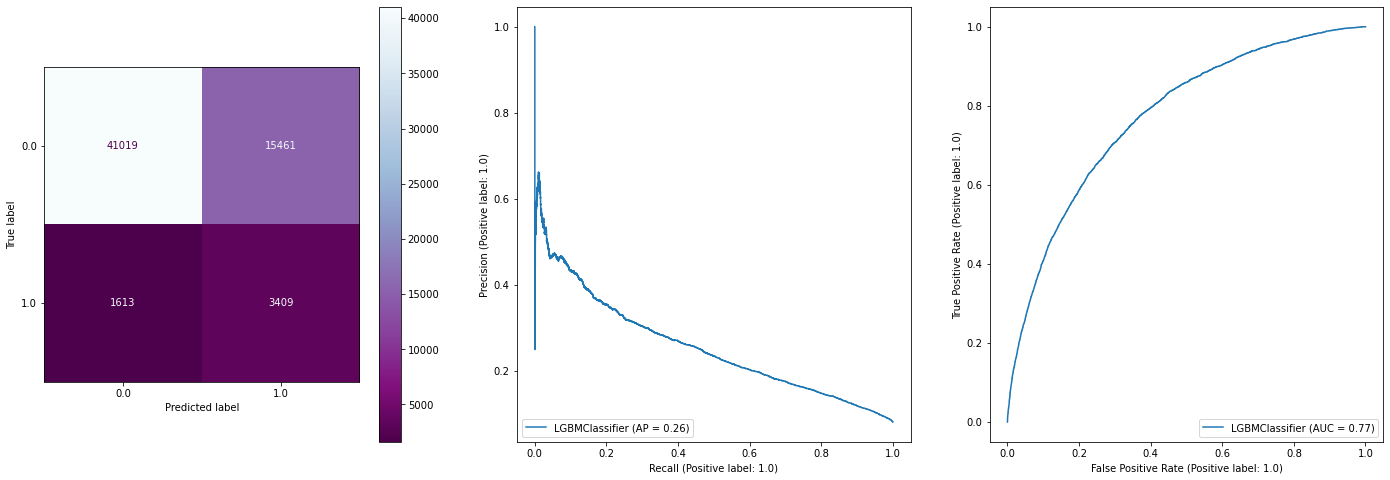

In [354]:
lgbmModel_classWeight = LGBMClassifier(n_jobs=-1, random_state=42, objective='binary', class_weight='balanced')

space = {
        'max_depth': hp.choice('max_depth', [None] + list(range(0, 22, 3)))
        }

lgbmClassifier_classWeight_results = dth.find_best_parameters(lgbmModel_classWeight, space, X_train_std, y_train, X_test_std, y_test, smote=False)

results['lgbmClassifier_classWeight'] = lgbmClassifier_classWeight_results

print(f"Best parameters : {lgbmClassifier_classWeight_results['Best params']}")

dth.plot_classifier_results(lgbmClassifier_classWeight_results['Classifier'], X_test_std, y_test)

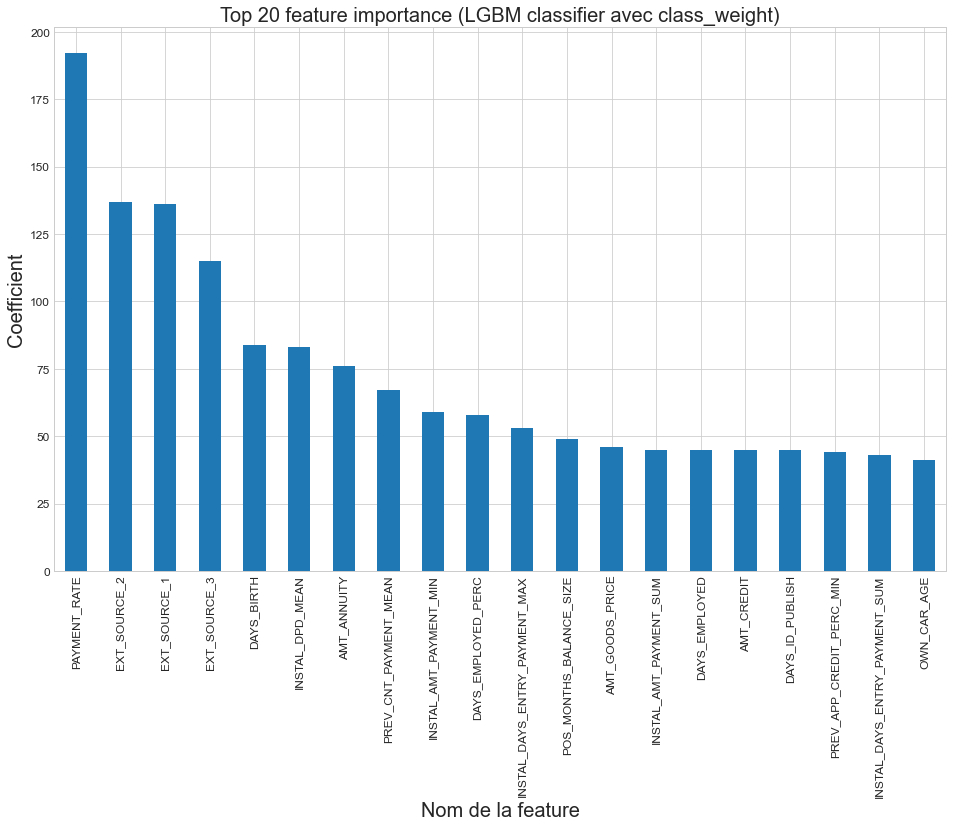

In [528]:
top_coefficients = pd.Series(
            lgbmClassifier_classWeight_results['Classifier'].feature_importances_,
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (LGBM classifier avec class_weight)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

100%|██████████| 10/10 [26:11<00:00, 157.19s/trial, best loss: 0.010325237291924963]
Meilleurs paramètres : {'C': 3.1306372213876936}


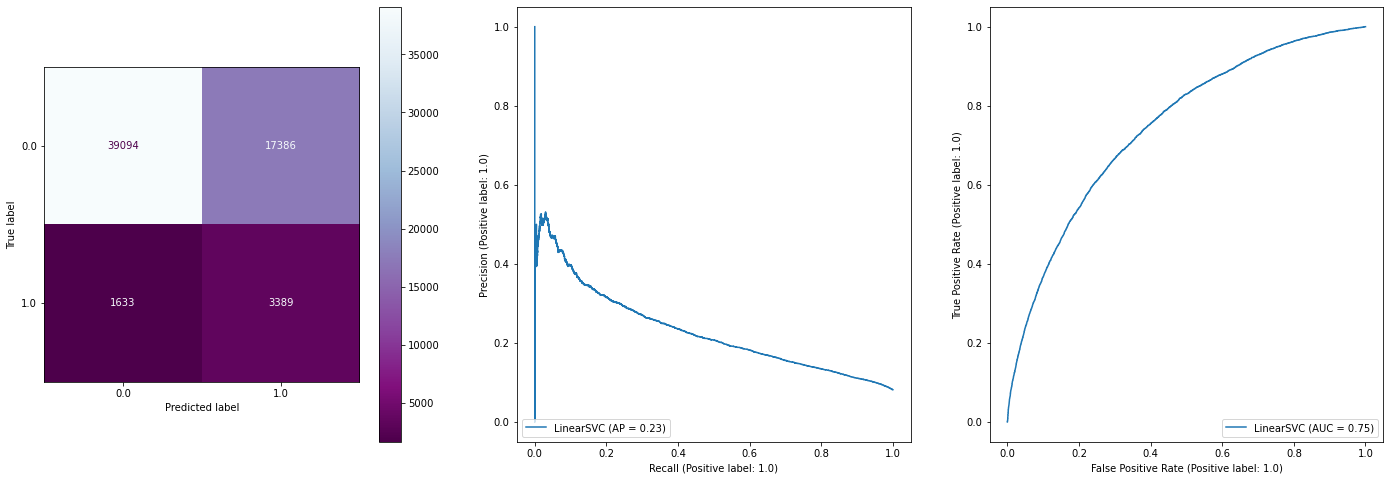

In [171]:
svcModel = LinearSVC(random_state=42, tol=1e-5, dual=False)

space = {
        'C': hp.loguniform('C', 1, 10),
        }

svc_results = dth.find_best_parameters(svcModel, space, X_train_std, y_train, X_test_std, y_test, smote=True)

results['svcClassifier'] = svc_results

print(f"Meilleurs paramètres : {svc_results['Best params']}")

dth.plot_classifier_results(svc_results['Classifier'], X_test_std, y_test)

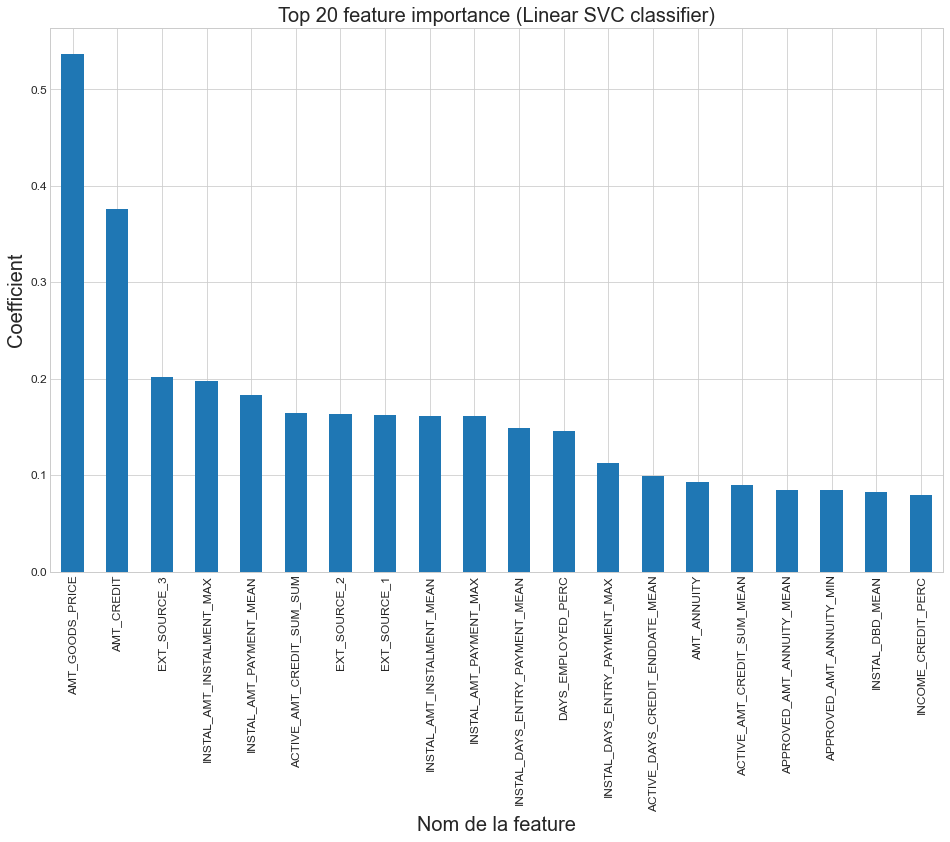

In [529]:
top_coefficients = pd.Series(
            svc_results['Classifier'].coef_[0],
            X_test_std.columns,
        ).map(abs).sort_values(ascending=False).head(20)

plt.figure(figsize=(16, 10))
top_coefficients.plot.bar()
plt.title('Top 20 feature importance (Linear SVC classifier)')
plt.xlabel('Nom de la feature')
plt.ylabel('Coefficient')
plt.show()

### Tableau récapitulatif

In [365]:
pd.DataFrame.from_dict(results, orient='index')

Classifier  \
dummyClassifier                     DummyClassifier(random_state=42, strategy='mos...   
ridgeClassifier_noSmote             RidgeClassifier(alpha=18370.500757440783, fit_...   
ridgeClassifier                     RidgeClassifier(alpha=0.7505689576188825, norm...   
randomForestClassifier              (DecisionTreeClassifier(max_depth=11, max_feat...   
lgbmClassifier                      LGBMClassifier(max_depth=3, objective='binary'...   
svcClassifier                       LinearSVC(C=3.1306372213876936, dual=False, ra...   
lgbmClassifier_classWeight          LGBMClassifier(class_weight='balanced', max_de...   
randomForestClassifier_classWeight  (DecisionTreeClassifier(max_depth=8, max_featu...   

                                                                          Best params  \
dummyClassifier                                         {'strategy': 'most_frequent'}   
ridgeClassifier_noSmote             {'alpha': 18370.500757440783, 'fit_intercept':...   
ridgeClassifier                     {'alpha': 0.7505689576188825, 'fit_intercept':...   
randomForestClassifier                      {'max_depth': 11, 'max_features': 'sqrt'}   
lgbmClassifier                                                       {'max_depth': 3}   
svcClassifier                                               {'C': 3.1306372213876936}   
lgbmClassifier_classWeight                                        {'max_depth': None}   
randomForestClassifier_classWeight           {'max_depth': 8, 'max_features': 'auto'}   

                                    Predict time  Training time  \
dummyClassifier                         0.000966       6.734963   
ridgeClassifier_noSmote                 0.011969     471.403331   
ridgeClassifier                         0.026902    1957.636500   
randomForestClassifier                  0.436888    4897.157357   
lgbmClassifier                          0.185503     685.200938   
svcClassifier                           0.019947    1571.873887   
lgbmClassifier_classWeight              0.191488     331.184315   
randomForestClassifier_classWeight      0.533574    2642.465243   

                                    Personnalised metric  \
dummyClassifier                                 0.018373   
ridgeClassifier_noSmote                         0.017622   
ridgeClassifier                                 0.013078   
randomForestClassifier                          0.014433   
lgbmClassifier                                  0.015577   
svcClassifier                                   0.013042   
lgbmClassifier_classWeight                      0.012186   
randomForestClassifier_classWeight              0.012997   

                                                  Confusion matrix  f1 score  \
dummyClassifier                            [[56480, 0], [5022, 0]]  0.000000   
ridgeClassifier_noSmote               [[52549, 3931], [4380, 642]]  0.133820   
ridgeClassifier                     [[39049, 17431], [1638, 3384]]  0.261950   
randomForestClassifier              [[44742, 11738], [2641, 2381]]  0.248785   
lgbmClassifier                       [[49578, 6902], [3491, 1531]]  0.227573   
svcClassifier                       [[39094, 17386], [1633, 3389]]  0.262744   
lgbmClassifier_classWeight          [[41019, 15461], [1613, 3409]]  0.285367   
randomForestClassifier_classWeight  [[41093, 15387], [1843, 3179]]  0.269544   

                                    accuracy  precision    recall       AUC  \
dummyClassifier                     0.918344   0.000000  0.000000  0.500000   
ridgeClassifier_noSmote             0.864866   0.140389  0.127838  0.652428   
ridgeClassifier                     0.689945   0.162575  0.673835  0.747171   
randomForestClassifier              0.766203   0.168638  0.474114  0.704938   
lgbmClassifier                      0.831014   0.181549  0.304859  0.690178   
svcClassifier                       0.690758   0.163129  0.674831  0.747505   
lgbmClassifier_classWeight          0.722383   0.180

Le meilleur modèle est le LinearSVC

### LIME and SHAP

In [488]:
y_pred = lgbmClassifier_classWeight_results['Classifier'].predict(X_test_std)

frame = {'true_value': y_test, 'predicted': y_pred}
data_target = pd.DataFrame(frame)
data_target.reset_index(inplace=True)

tp_list = data_target[(data_target['true_value'] == 1) & (data_target['predicted'] == 1)].index.tolist()
tn_list = data_target[(data_target['true_value'] == 0) & (data_target['predicted'] == 0)].index.tolist()
fp_list = data_target[(data_target['true_value'] == 0) & (data_target['predicted'] == 1)].index.tolist()
fn_list = data_target[(data_target['true_value'] == 1) & (data_target['predicted'] == 0)].index.tolist()

#### True Positive

In [490]:
tp_index = random.choice(tp_list)
dth.lime(lgbmClassifier_classWeight_results['Classifier'], tp_index, X_train_std, X_test_std, y_test)

Vraie valeur : 1.0


In [491]:
explainer = shap.Explainer(lgbmClassifier_classWeight_results['Classifier'])
shap_values = explainer.shap_values(X_test_std)

print(f"Vraie valeur : {y_test.iloc[tp_index]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][tp_index,:], X_test_std.iloc[tp_index,:])

Vraie valeur : 1.0


#### True Negative

In [492]:
tn_index = random.choice(tn_list)
dth.lime(lgbmClassifier_classWeight_results['Classifier'], tn_index, X_train_std, X_test_std, y_test)

Vraie valeur : 0.0


In [493]:
explainer = shap.Explainer(lgbmClassifier_classWeight_results['Classifier'])
shap_values = explainer.shap_values(X_test_std)

print(f"Vraie valeur : {y_test.iloc[tn_index]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][tn_index,:], X_test_std.iloc[tn_index,:])

Vraie valeur : 0.0


#### False Positive

In [496]:
fp_index = random.choice(fp_list)
dth.lime(lgbmClassifier_classWeight_results['Classifier'], fp_index, X_train_std, X_test_std, y_test)

Vraie valeur : 0.0


In [497]:
explainer = shap.Explainer(lgbmClassifier_classWeight_results['Classifier'])
shap_values = explainer.shap_values(X_test_std)

print(f"Vraie valeur : {y_test.iloc[fp_index]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][fp_index,:], X_test_std.iloc[fp_index,:])

Vraie valeur : 0.0


#### False Negative

In [498]:
fn_index = random.choice(fn_list)
dth.lime(lgbmClassifier_classWeight_results['Classifier'], fn_index, X_train_std, X_test_std, y_test)

Vraie valeur : 1.0


In [499]:
explainer = shap.Explainer(lgbmClassifier_classWeight_results['Classifier'])
shap_values = explainer.shap_values(X_test_std)

print(f"Vraie valeur : {y_test.iloc[fn_index]}")
shap.force_plot(explainer.expected_value[1], shap_values[1][fn_index,:], X_test_std.iloc[fn_index,:])

Vraie valeur : 1.0
